### Predicting the customer churn for health clubs. Machine Learning.

##### Table of contents

0. [Introduction](#introduction)
1. [Download the data.](#step_1)<br />
1.1 [Loading data in an optimized form.](#loading_data)<br />
2. [Carry out exploratory data analysis](#EDA)<br />
2.1 [Data preprocessing](#preprocessing)<br />
2.2 [Let's compare the average values of features in two groups](#step22)<br />
2.3 [Distribution of characteristics among customers who left (churn) and those who stayed](#distribution)<br />
2.4 [Correlation matrix between customer features](#matrix)<br />
3. [Build a model to predict user churn](#model_predict)<br />
3.1 [Let's divide the data into train and validation sets.](#divide)<br />
3.2 [Let's train the model on the train set with "Logistic regression" method.](#lr)<br />
3.3 [Let's train the model on the train set with "Random forest" method.](#rf)<br />
4. [Create user clusters](#clusters)<br />
4.1 [Standardize the data and plot a dendrogram](#dendrogram)<br />
4.2 [Let's train the model on the train set with "K-means" algorithm.](#k_means)<br />
4.3 [The mean feature values for clusters.](#mean)<br />
4.4 [Plot distributions of features for the clusters.](#distributions)<br />
4.5 [Calculate the churn rate for each cluster](#calculate)<br />
5.  [Conclusions and basic recommendations](#conclusions)<br />
5.1 [Overall conclusion.](#overall_conclusion)<br />
5.2 [Recommendations.](#recommendations)


Introduction<a name="introduction"></a><br /><br />

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.<br />
My task is to analyze customer profiles and come up with a customer retention strategy.

Plan:<br>
 - We will develop a model to predict the likelihood of churn for each customer.

 - We will create profiles of typical users by identifying the most significant groups and describing their key characteristics.

 - We will analyze the factors that have the greatest impact on churn.

 - Finally, we will summarize our findings and provide recommendations to enhance customer service.

#### Description of the data <br />

Dataset "gym_churn_us.csv"

- **gender** (rename - man)
- **Near_Location** — whether the user lives or works in the neighborhood where the gym is located
- **Partner** — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
- **Promo_friends** — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
- **Phone** — whether the user provided their phone number
- **Age**
- **Lifetime** — the time (in months) since the customer first came to the gym
Data from the log of visits and purchases and data on current membership status
- **Contract_period** — 1 month, 3 months, 6 months, or 1 year
- **Month_to_end_contract** — the months remaining until the contract expires
- **Group_visits** — whether the user takes part in group sessions
- **Avg_class_frequency_total** — average frequency of visits per week over the customer's lifetime
- **Avg_class_frequency_current_month** — average frequency of visits per week over the preceding month (rename - frequency_current_month)
- **Avg_additional_charges_total** — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.


#### Step 1. Download the data.<a name="step_1"></a>

In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,286 kB]
Get:14 http:/

In [2]:
pip install --upgrade lazypredict

In [3]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 4.4 MB/s eta 0:00:00


In [4]:
pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.24.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [5]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [6]:
# 1. Read in the yandex S3 bucket into a DataFrame.
from pyspark import SparkFiles
url = "https://code.s3.yandex.net/datasets/gym_churn_us.csv"
spark.sparkContext.addFile(url)
gym = spark.read.csv(SparkFiles.get("gym_churn_us.csv"), header=True, inferSchema=True)

In [7]:
#code for platform
%pip install --upgrade plotly
import plotly
print(plotly.__version__)

5.24.1


In [8]:

import pandas   as pd
import warnings
# math
from scipy import stats as st
import numpy as np
import math

# graph
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, silhouette_score
from lazypredict.Supervised import LazyClassifier  # Use LazyClassifier for classification tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [9]:
# all output will be visible without needing to scroll through a limited space
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
# constants and settings
pd.options.display.float_format = "{:.2f}".format
color_dict = ['#00b894','#fdcb6e','#d63031','#0984e3','#e84393','#6c5ce7']
warnings.simplefilter("ignore", UserWarning)

In [11]:
gym.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- Near_Location: integer (nullable = true)
 |-- Partner: integer (nullable = true)
 |-- Promo_friends: integer (nullable = true)
 |-- Phone: integer (nullable = true)
 |-- Contract_period: integer (nullable = true)
 |-- Group_visits: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Avg_additional_charges_total: double (nullable = true)
 |-- Month_to_end_contract: double (nullable = true)
 |-- Lifetime: integer (nullable = true)
 |-- Avg_class_frequency_total: double (nullable = true)
 |-- Avg_class_frequency_current_month: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [12]:
gym.show(5)

+------+-------------+-------+-------------+-----+---------------+------------+---+----------------------------+---------------------+--------+-------------------------+---------------------------------+-----+
|gender|Near_Location|Partner|Promo_friends|Phone|Contract_period|Group_visits|Age|Avg_additional_charges_total|Month_to_end_contract|Lifetime|Avg_class_frequency_total|Avg_class_frequency_current_month|Churn|
+------+-------------+-------+-------------+-----+---------------+------------+---+----------------------------+---------------------+--------+-------------------------+---------------------------------+-----+
|     1|            1|      1|            1|    0|              6|           1| 29|          14.227470422861144|                  5.0|       3|      0.02039794762085778|                              0.0|    0|
|     0|            1|      0|            0|    1|             12|           1| 31|          113.20293765105819|                 12.0|       7|       1.92293605

In [13]:
# Step 3: Register the DataFrame as a temporary view
gym.createOrReplaceTempView("class_data")

# Step 4: Execute the SQL query to calculate the average
avg_query = """
SELECT AVG(Avg_class_frequency_total) AS avg_frequency
FROM class_data
"""

# Running the SQL query
avg_result = spark.sql(avg_query)

# Show the result
avg_result.show()

+-----------------+
|    avg_frequency|
+-----------------+
|1.879019712534941|
+-----------------+



In [14]:
# Step 4: Execute the SQL query to count churn occurrences
churn_query = """
SELECT
    Churn,
    COUNT(*) AS churn_count
FROM class_data
GROUP BY Churn
"""

# Running the SQL query
churn_counts = spark.sql(churn_query)

# Show the results
churn_counts.show()

# To extract the churn counts into variables
non_churned_count = churn_counts.filter(churn_counts.Churn == 0).select("churn_count").collect()[0][0]
churned_count = churn_counts.filter(churn_counts.Churn == 1).select("churn_count").collect()[0][0]

# Print the results
print(f"Non-Churned Count: {non_churned_count}")
print(f"Churned Count: {churned_count}")

+-----+-----------+
|Churn|churn_count|
+-----+-----------+
|    1|       1061|
|    0|       2939|
+-----+-----------+

Non-Churned Count: 2939
Churned Count: 1061


In [15]:
# Stop the Spark session when done
spark.stop()

##### 1.1 Loading data in an optimized form.<a name="loading_data"></a>

In [16]:
# Preliminary analysis of the data structure.
gym_path   = 'gym_churn_us.csv'
platform_path = 'https://code.s3.yandex.net/datasets/'

try:
    gym   = pd.read_csv(gym_path)
except:
    gym  = pd.read_csv(platform_path+gym_path)

#### Step 2. Carry out exploratory data analysis (EDA)<a name="EDA"></a>

#### 2.1 Data preprocessing<a name="preprocessing"></a>

In [17]:
# Display the summary information about the DataFrame
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

##### **Conclusion:**<br /><br />
No missing data found. <br />
With the data, we need to make the following transformations:
- We need to convert the Month_to_end_contract field to the Integer type
- For convenience, we need to rename the columns. We will make all letters small.
- Despite the fact that the Contract_period field has a digital value, in fact, it is a categorical field, and for the convenience of data processing, we need to convert it into three binary columns.

In [18]:
# Convert the Month_to_end_contract column in a DataFrame named gym to integers
try:
    gym['Month_to_end_contract']  = gym['Month_to_end_contract'].astype('int')
except:
    print('Failed')

In [19]:
# Renaming columns
gym = gym.rename(columns=
                 {'Avg_class_frequency_total':'frequency_total',
                  'Avg_class_frequency_current_month':'frequency_current_month',
                  'Month_to_end_contract':'Month_to_end',
                  'Avg_additional_charges_total':'charges_for_services',
                  'gender':'man'})
# Display the updated column names for verification
gym = gym.rename(str.lower, axis='columns')

In [20]:
# Let's convert data from the contract_period column to a categorical type.
gym['contract'] = (
    gym['contract_period'].map({1: '1m', 6: '6m',12:'year'})
)
gym = gym.drop(['contract_period'], axis =1)
# Let's convert the categorical column "contract_period" to three binary columns
gym = pd.get_dummies(gym)

In [21]:
# Display two random samples from the updated DataFrame
gym.sample(2)

,man,near_location,partner,promo_friends,phone,group_visits,age,charges_for_services,month_to_end,lifetime,frequency_total,frequency_current_month,churn,contract_1m,contract_6m,contract_year
1699,1,1,1,1,1,1,34,149.88,6,8,1.35,1.37,0,False,False,True
1316,0,0,1,0,1,0,29,260.22,1,2,3.28,3.26,0,True,False,False


In [22]:
# Check for duplicates after data manipulation
print('Duplicates found - ',gym.duplicated().sum(),' records')

Duplicates found -  0  records


##### Let's estimate the mean and standard deviation

In [23]:
# Get statistical summary and select specific statistics
gym.describe().loc[['min','mean','std','max']].T

,min,mean,std,max
man,0.00,0.51,0.50,1.00
near_location,0.00,0.85,0.36,1.00
partner,0.00,0.49,0.50,1.00
promo_friends,0.00,0.31,0.46,1.00
phone,0.00,0.90,0.30,1.00
group_visits,0.00,0.41,0.49,1.00
age,18.00,29.18,3.26,41.00
charges_for_services,0.15,146.94,96.36,552.59
month_to_end,1.00,4.32,4.19,12.00
lifetime,0.00,3.72,3.75,31.00


Comment
    
Note that variables have quite different standard deviations. This means it is worth scaling our data. For instance, we can use standartization.

In [24]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
scaled_data = scaler.fit_transform(gym)

# Convert the scaled data back to a DataFrame
scaled_gym = pd.DataFrame(scaled_data, columns=gym.columns)

# Display the standardized DataFrame
scaled_gym

,man,near_location,partner,promo_friends,phone,group_visits,age,charges_for_services,month_to_end,lifetime,frequency_total,frequency_current_month,churn,contract_1m,contract_6m,contract_year
0,0.98,0.43,1.03,1.50,-3.06,1.19,-0.06,-1.38,0.16,-0.19,-1.91,-1.68,-0.60,-1.11,1.95,-0.56
1,-1.02,0.43,-0.97,-0.67,0.33,1.19,0.56,-0.35,1.83,0.87,0.05,0.14,-0.60,-1.11,-0.51,1.78
2,-1.02,0.43,1.03,-0.67,0.33,-0.84,-0.36,-0.18,-0.79,-0.46,-0.02,-0.03,-0.60,0.90,-0.51,-0.56
3,-1.02,0.43,1.03,1.50,0.33,1.19,1.17,-0.87,1.83,-0.46,1.36,1.51,-0.60,-1.11,-0.51,1.78
4,0.98,0.43,1.03,1.50,0.33,-0.84,-0.98,0.53,-0.79,-0.19,-0.79,-0.61,-0.60,0.90,-0.51,-0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.98,0.43,1.03,-0.67,0.33,-0.84,1.17,-1.50,1.83,1.14,0.42,0.55,-0.60,-1.11,-0.51,1.78
3996,-1.02,0.43,-0.97,-0.67,0.33,1.19,-0.06,-0.81,-0.79,-0.73,-0.62,-1.40,1.66,0.90,-0.51,-0.56
3997,0.98,0.43,1.03,1.50,0.33,-0.84,-0.36,-0.71,1.59,-0.46,0.93,1.01,-0.60,-1.11,-0.51,1.78
3998,-1.02,0.43,1.03,1.50,0.33,-0.84,0.86,-0.88,0.16,-0.19,-0.26,-0.16,-0.60,-1.11,1.95,-0.56


In [25]:
# Get statistical summary and select specific statistics
scaled_gym.describe().loc[['min','mean','std','max']].T

,min,mean,std,max
man,-1.02,0.00,1.00,0.98
near_location,-2.34,0.00,1.00,0.43
partner,-0.97,-0.00,1.00,1.03
promo_friends,-0.67,-0.00,1.00,1.50
phone,-3.06,0.00,1.00,0.33
group_visits,-0.84,-0.00,1.00,1.19
age,-3.43,0.00,1.00,3.63
charges_for_services,-1.52,-0.00,1.00,4.21
month_to_end,-0.79,-0.00,1.00,1.83
lifetime,-0.99,0.00,1.00,7.28


Comment
 - Each feature now has been transformed so that the distribution of values for each feature has a mean of 0 and a standard deviation of 1.
 - This scaling allows machine learning algorithms to treat all features equally without being biased toward the features with larger ranges.

#### 2.2 Let's compare the average values of features in two groups: for those who left (churn), and for those who stayed.<a name="step22"></a>

In [26]:
gym_churn = (
    scaled_gym.groupby('churn').mean().transpose()
)
# Rename the columns for clarity
gym_churn.columns = ['Not Churned', 'Churned']

# Display the result
gym_churn

,Not Churned,Churned
man,-0.00,0.00
near_location,0.08,-0.21
partner,0.09,-0.26
promo_friends,0.10,-0.27
phone,0.00,-0.00
group_visits,0.11,-0.29
age,0.24,-0.67
charges_for_services,0.12,-0.33
month_to_end,0.23,-0.63
lifetime,0.26,-0.73


By dividing the data into 2 groups (clients who left / clients who stay), the following conclusions can be drawn:
- Men and women are evenly distributed among the groups.
- Clients who live closer to the gym are more loyal customers.
- Clients working in partner companies are more loyal customers.
- Customers who came through the "bring a friend" promo are more loyal customers.
- More customer churn among those who bought a gym membership for a shorter period.
- Loyal clients are eager to attend group classes.
- Loyal customers spend more money on additional services for the entire duration of the subscription. However, due to the fact that loyal customers go to the gym on average 5 times longer, and if we compare the costs of additional services per month, it turns out that customers who are inclined to stop exercising spend more money.
- Not loyal customers, usually buy a gym membership for a small number of months. On average, they drop out when they still have 1.7 months left until the end of their contract, while loyal customers, on average, have 5 months until the end of their contract.
- Loyal customers visit the gym more often.
- Most clients who quit going to the gym did so in the first 2 months.

#### 2.3 Distribution of characteristics among customers who left (churn) and those who stayed<a name="distribution"></a>

In [27]:
# Define the lists
category_data_list = ['man',
                      'near_location',
                      'partner',
                      'promo_friends',
                      'phone',
                      'group_visits',
                      'churn']
contract_data_list = ['contract_1m',
                      'contract_6m',
                      'contract_year']
numeric_data_list = ['age',
                     'charges_for_services',
                     'month_to_end',
                     'lifetime',
                     'frequency_total',
                     'frequency_current_month',
                     'churn']

In [28]:
# Create gym_binary_stayed DataFrame
gym_binary_stayed = gym[category_data_list + contract_data_list].query('churn == 0').reset_index(drop=True)
# Count of non-churned members
count_stayed = len(gym_binary_stayed)

# Summing the binary columns
gym_binary_stayed = (
    gym_binary_stayed.
    drop(['churn'], axis = 1).
    sum().
    reset_index().
    rename(columns={0:"count"})
)
# Calculate ratios
gym_binary_stayed['ratio'] = gym_binary_stayed['count']/count_stayed

In [29]:
# Create gym_binary_churn DataFrame
gym_binary_churn = gym[category_data_list + contract_data_list].query('churn == 1').reset_index(drop=True)
# Count of churned members
count_churn = len(gym_binary_churn)

# Summing the binary columns
gym_binary_churn = (
    gym_binary_churn.
    drop(['churn'], axis = 1).
    sum().
    reset_index().
    rename(columns={0:"count"})
)
# Calculate ratios
gym_binary_churn['ratio'] = gym_binary_churn['count']/count_churn

In [30]:
# create a bar chart
def plot_bar(fig, x_label, data, name, type_color):
    if type_color == 'green':
        color = dict(color='rgba(50, 171, 96, 0.6)',
                     line=dict(
                         color='rgba(50, 171, 96,  1.0)',
                         width=1),
                    )
    else:
        color = dict(color='rgba(249, 202, 36, 0.6)',
                     line=dict(
                         color='rgba(249, 202, 36, 1.0)',
                         width=1),
                    )

    fig.add_trace(go.Bar(x=x_label,
                     y=data,
                     text=data,
                     name = name,
                     texttemplate='%{text:.1%}',
                     textposition='outside',
                     textfont_size=14,
                     marker= color
                    ))
def update_layout(fig, title, yaxis_title = 'Share of customers'):
    fig.update_layout(
        title=title,
        xaxis_tickfont_size=14,
        yaxis=dict(
            title=yaxis_title,
            titlefont_size=16,
            tickfont_size=14,
        ),
        bargroupgap=0.1 # gap between bars of the same location coordinate.
    )

In [31]:
#let's built graph Distribution of characteristics
xasix_list = ['Man','Near location','Partner','Promo','Phone','Group visits']
fig = go.Figure()
plot_bar(fig, xasix_list, gym_binary_stayed.query('index in @category_data_list').ratio, "Customers stayed", 'green')
plot_bar(fig, xasix_list, gym_binary_churn.query('index in @category_data_list').ratio, "Customers left", 'yellow')

update_layout(fig,'Distribution of characteristics among customers who left (churn) and those who stayed')

fig.show()

- Men and women are evenly distributed among the groups.
- Clients who live closer to the gym are more loyal customers.
- Clients working in partner companies are more loyal customers.
- Customers who came through the "bring a friend" promo are more loyal customers.
- Loyal clients are eager to attend group classes.

In [32]:
#let's built graph Distribution of contract term
xasix_list = ['Monthly contract','6 months contract','Contract for a year']

fig = go.Figure()
plot_bar(fig, xasix_list, gym_binary_stayed.query('index in @contract_data_list').ratio, "Customers stayed", 'green')
plot_bar(fig, xasix_list, gym_binary_churn.query('index in @contract_data_list').ratio, "Customers left", 'yellow')

update_layout(fig, 'Distribution of the contract term among clients who left (churn) and remained')

fig.show()

Non-loyal customers usually buy a gym membership for one month. Clients who buy a one-year contract very rarely stop going to the gym.

In [33]:
# Let's create a table from non-binary columns
gym_numeric_stayed = gym[numeric_data_list].reset_index(drop=True)
gym_numeric_stayed['type'] = (
    gym_numeric_stayed['churn'].map({True: 'Customers left', False: 'Customers stayed'})
)

In [34]:
# create a histogram using Plotly Expres
def plot_histogram(column, title, xaxis_title):
    fig = go.Figure()
    fig = px.histogram(gym_numeric_stayed,
                       x=column,
                       color = 'type',
                       title=title,
                       barmode = "stack",
                       color_discrete_sequence=color_dict,
                       #                    nbins = 46,
                       labels = {'type': ''}
                      )
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)
    fig.update_layout(yaxis_title="Number of clients",xaxis_title=xaxis_title)
    fig.show()

In [35]:
# build a graph
plot_histogram('age', 'Distribution of clients by age','Age')

As we can see in the graph, younger clients are more likely to stop going to the gym.

In [36]:
# Call the function to plot a histogram for 'charges_for_services'
plot_histogram('charges_for_services',
               'Distribution of clients by the total amount of money spent on other gym services',
               'The total amount, $')


Loyal customers spend more money on additional services for the entire duration of the subscription. However, due to the fact that loyal customers go to the gym on average 5 times longer, and if we compare the costs of additional services per month, it turns out that customers who are inclined to stop exercising spend more money.

In [37]:
# Call the function to plot a histogram for 'month_to_end'
plot_histogram('month_to_end',
               'Distribution of clients by the number of months left before the expiration of the contract',
               'Months')

Non-loyal customers usually buy a gym membership for one month. Clients who buy a one-year contract very rarely stop going to the gym.

In [38]:
# Call the function to plot a histogram for 'lifetime'
plot_histogram('lifetime',
               'Distribution of clients by the time since the customer first came to the gym',
               'Months')

Most clients who quit going to the gym did so in the first 2 months.

In [39]:
# Call the function to plot a histogram for 'frequency_total'
plot_histogram('frequency_total',
               "Average frequency of visits per week over the customer's lifetime",
               'Average frequency of visits per week')


Loyal customers visit the gym more often.

In [40]:
# Call the function to plot a histogram for 'frequency_current_month'
plot_histogram('frequency_current_month',
               'Average frequency of visits per week over the preceding month',
               'Average frequency of visits per week')

Loyal customers visit the gym more often.

#### 2.4 Correlation matrix between customer features<a name="matrix"></a>

In [41]:
# Calculate the correlation matrix
gym_heatmap = gym.corr()

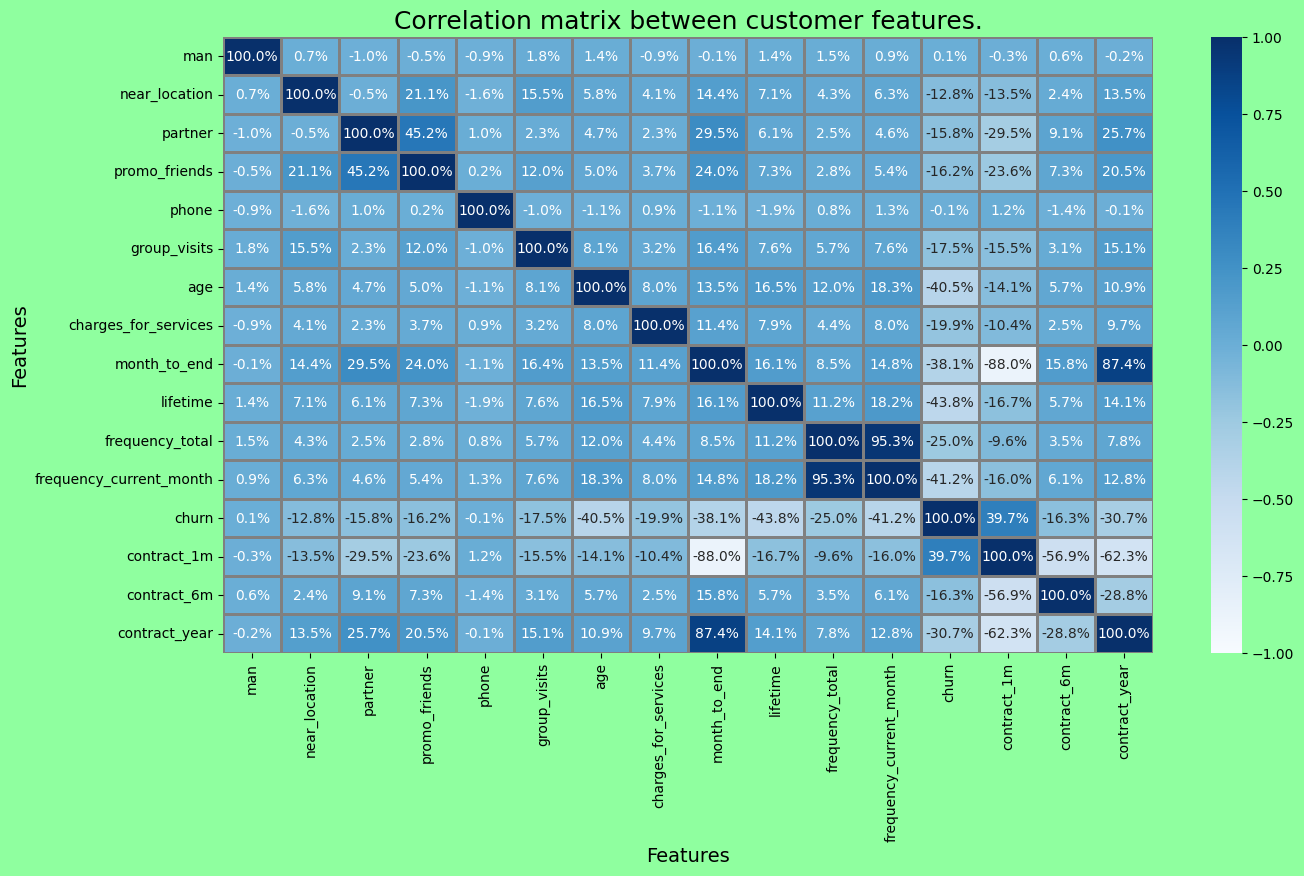

In [42]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 8))
fig.patch.set_facecolor('xkcd:mint green')
# Set the title
plt.title('Correlation matrix between customer features.', fontsize=18)

# Create the heatmap
sns.heatmap(gym_heatmap,
            annot= True,
            fmt = '.1%',
            linewidths = 1,
            linecolor = 'grey',
            vmin = -1,
            vmax = 1,
            cmap = 'Blues',
            yticklabels = True,
           )
# Set the axis labels
ax.set_ylabel('Features', fontsize=14)
ax.set_xlabel('Features', fontsize=14)

# Show the plot
plt.show()

We see that there is multicollinearity, two pairs of strongly correlated features are found:

`Avg_class_frequency_total`

`Avg_class_frequency_current_month`

and

`Month_to_end_contract`

`Contract_period`

We exclude one feature from each pair, keeping `Avg_class_frequency_total` and `Contract_period`

In [43]:
#We split the data into training and validation samples using the train_test_split() function.
X = gym.drop('churn', axis = 1)
y = gym['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
# 1. Calculate the correlation matrix
correlations = X_train.corr()

# 2. Calculate the distribution of the target variable
target_distribution = y_train.value_counts(normalize=True)
print("\nTarget Variable Distribution:")
target_distribution


Target Variable Distribution:


,proportion
churn,
0,0.73
1,0.27


Accuracy
Base Accuracy: 0.73

If we only label all observations as 0, we will be correct 73% of the time.

Since we plan to use the **"Logistic regression"** model to predict customer churn, we need to remove one of the features in each pair. There is no need to remove highly correlated features for the **"Random forest"** algorithm. (We conducted an experiment and the "Random forest" algorithm on full data gives a better forecasting result)

In [44]:
# Drop specified columns
gym_lr = gym.drop(['month_to_end','frequency_total'],axis = 1)

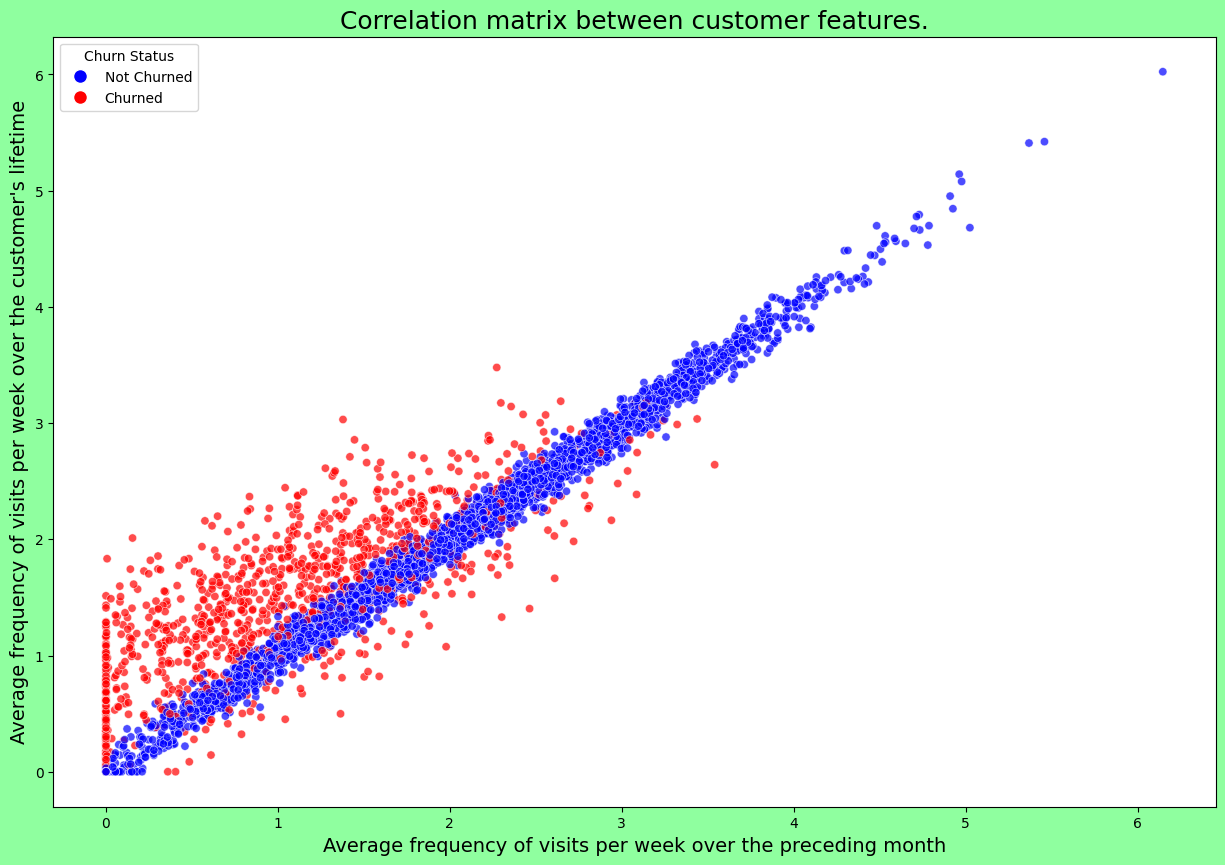

In [45]:
# Set the figure and axes for the plot
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('xkcd:mint green')
# Title of the plot
plt.title('Correlation matrix between customer features.', fontsize=18)

# Create a scatter plot
sns.scatterplot(data=gym,
                x='frequency_current_month',
                y='frequency_total',
                hue='churn',
                palette={0: 'blue', 1: 'red'},  # Custom colors for churn status
                alpha=0.7,  # Set transparency for better visibility
                ax=ax)

# Set labels
ax.set_ylabel("Average frequency of visits per week over the customer's lifetime", fontsize=14)
ax.set_xlabel('Average frequency of visits per week over the preceding month', fontsize=14)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Not Churned')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Churned')
plt.legend(handles=[blue_patch, red_patch], title='Churn Status', loc='upper left')

# Show the plot
plt.show()

Conclusion: <br />
As we can see, for clients who continue to visit the gym, the frequency of visits does not change, however, for those who left, the frequency of visits has decreased in the last month, compared to the previous period.

# **Building a churn prediction model**
We are going to build a binary classification model of customers, where the target feature is the fact that a customer leaves in the next month:

**We plan to:**

Split the data into training and validation samples using the `train_test_split()` function.

Train the model on the train sample in two ways:

`LazyPredict`,

`AdaBoostClassifier`

`logistic regression`,

`random forest`.


Evaluate the accuracy, precision, and recall metrics for both models on the validation set.

Compare models by them, determine which model performed better based on the metrics.

(**Hint**: don't forget to specify the random_state parameter when splitting the sample and specifying the algorithm)

### Step 3. Build a model to predict user churn<a name="model_predict"></a>

**LazyPredict**

In [46]:
import sklearn
print(sklearn.__version__)

1.1.3


In [47]:
# Preliminary analysis of the data structure.
gym_path   = 'gym_churn_us.csv'
platform_path = 'https://code.s3.yandex.net/datasets/'

try:
    gym1   = pd.read_csv(gym_path)
except:
    gym1  = pd.read_csv(platform_path+gym_path)

# Assuming 'gym' is your DataFrame with the 'churn' column
# Define the feature columns and target variable
X = gym1.drop(columns=['Churn'])
y = gym1['Churn']

# Identify categorical columns for one-hot encoding
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=True), categorical_cols)
    ],
    remainder='passthrough'
)

# Create a preprocessing and model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit the pipeline to the data and transform it
X_transformed = pipeline.fit_transform(X)

# Check the transformed shape
print("Transformed shape:", X_transformed.shape)

# Split the transformed data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

# Check the distribution of classes in the train and test sets
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

# Initialize LazyClassifier and fit the model
clf = LazyClassifier(verbose=1, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Display the results
print(models)

Transformed shape: (4000, 13)
Train class distribution:
 Churn
0    2042
1     758
Name: count, dtype: int64
Test class distribution:
 Churn
0    897
1    303
Name: count, dtype: int64


  7%|▋         | 2/29 [00:00<00:04,  6.61it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.925, 'Balanced Accuracy': 0.8941024537236333, 'ROC AUC': 0.8941024537236332, 'F1 Score': 0.9244915936776404, 'Time taken': 0.21085047721862793}
{'Model': 'BaggingClassifier', 'Accuracy': 0.9066666666666666, 'Balanced Accuracy': 0.8621698290230361, 'ROC AUC': 0.8621698290230361, 'F1 Score': 0.9052413793103447, 'Time taken': 0.10551071166992188}
{'Model': 'BernoulliNB', 'Accuracy': 0.8525, 'Balanced Accuracy': 0.8270306963806748, 'ROC AUC': 0.8270306963806748, 'F1 Score': 0.8554485928736869, 'Time taken': 0.02067089080810547}


 28%|██▊       | 8/29 [00:00<00:01, 15.09it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.93, 'Balanced Accuracy': 0.8974469353289845, 'ROC AUC': 0.8974469353289843, 'F1 Score': 0.9292762535477768, 'Time taken': 0.225677490234375}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.8866666666666667, 'Balanced Accuracy': 0.8531629082640706, 'ROC AUC': 0.8531629082640706, 'F1 Score': 0.8870320656226697, 'Time taken': 0.05025959014892578}
{'Model': 'DummyClassifier', 'Accuracy': 0.7475, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.6394921316165951, 'Time taken': 0.02048325538635254}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.8516666666666667, 'Balanced Accuracy': 0.7980617459739285, 'ROC AUC': 0.7980617459739285, 'F1 Score': 0.8508333829372461, 'Time taken': 0.02374553680419922}


 34%|███▍      | 10/29 [00:01<00:01,  9.81it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.9041666666666667, 'Balanced Accuracy': 0.8604975882203605, 'ROC AUC': 0.8604975882203605, 'F1 Score': 0.9028828408276701, 'Time taken': 0.3389592170715332}
{'Model': 'GaussianNB', 'Accuracy': 0.86, 'Balanced Accuracy': 0.856087949932117, 'ROC AUC': 0.856087949932117, 'F1 Score': 0.8647039625288904, 'Time taken': 0.0159146785736084}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.8675, 'Balanced Accuracy': 0.82832212987185, 'ROC AUC': 0.82832212987185, 'F1 Score': 0.8679970121349496, 'Time taken': 0.12892413139343262}


 41%|████▏     | 12/29 [00:01<00:03,  4.86it/s]

{'Model': 'LabelPropagation', 'Accuracy': 0.83, 'Balanced Accuracy': 0.7912182522600086, 'ROC AUC': 0.7912182522600086, 'F1 Score': 0.8325638557309716, 'Time taken': 0.741647481918335}


 48%|████▊     | 14/29 [00:03<00:04,  3.02it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.8266666666666667, 'Balanced Accuracy': 0.7868030950252216, 'ROC AUC': 0.7868030950252215, 'F1 Score': 0.8292807940786378, 'Time taken': 1.1417198181152344}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.9258333333333333, 'Balanced Accuracy': 0.8651555791030607, 'ROC AUC': 0.8651555791030608, 'F1 Score': 0.9225587964656821, 'Time taken': 0.08425641059875488}


 59%|█████▊    | 17/29 [00:03<00:02,  4.56it/s]

{'Model': 'LinearSVC', 'Accuracy': 0.93, 'Balanced Accuracy': 0.8974469353289845, 'ROC AUC': 0.8974469353289843, 'F1 Score': 0.9292762535477768, 'Time taken': 0.15567731857299805}
{'Model': 'LogisticRegression', 'Accuracy': 0.925, 'Balanced Accuracy': 0.8897314480611941, 'ROC AUC': 0.8897314480611941, 'F1 Score': 0.9241335874559267, 'Time taken': 0.0682990550994873}
{'Model': 'NearestCentroid', 'Accuracy': 0.8216666666666667, 'Balanced Accuracy': 0.8501164497720675, 'ROC AUC': 0.8501164497720675, 'F1 Score': 0.8314954428500109, 'Time taken': 0.04422712326049805}


 72%|███████▏  | 21/29 [00:04<00:01,  5.10it/s]

{'Model': 'NuSVC', 'Accuracy': 0.8708333333333333, 'Balanced Accuracy': 0.7748214620793183, 'ROC AUC': 0.7748214620793182, 'F1 Score': 0.8615999618651087, 'Time taken': 0.6766772270202637}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.8925, 'Balanced Accuracy': 0.7969634756117752, 'ROC AUC': 0.7969634756117753, 'F1 Score': 0.8835788594607493, 'Time taken': 0.02962207794189453}
{'Model': 'Perceptron', 'Accuracy': 0.9058333333333334, 'Balanced Accuracy': 0.8506849012660462, 'ROC AUC': 0.8506849012660463, 'F1 Score': 0.9032087160832002, 'Time taken': 0.03641533851623535}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.9125, 'Balanced Accuracy': 0.9141527865161099, 'ROC AUC': 0.9141527865161099, 'F1 Score': 0.9147566201731392, 'Time taken': 0.054525136947631836}


 79%|███████▉  | 23/29 [00:04<00:01,  3.99it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9141666666666667, 'Balanced Accuracy': 0.8715575570935019, 'ROC AUC': 0.871557557093502, 'F1 Score': 0.9128016975242778, 'Time taken': 0.7048983573913574}
{'Model': 'RidgeClassifier', 'Accuracy': 0.9216666666666666, 'Balanced Accuracy': 0.8558120026049427, 'ROC AUC': 0.8558120026049427, 'F1 Score': 0.9177702419861216, 'Time taken': 0.033843278884887695}


 86%|████████▌ | 25/29 [00:05<00:00,  4.71it/s]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9216666666666666, 'Balanced Accuracy': 0.8558120026049427, 'ROC AUC': 0.8558120026049427, 'F1 Score': 0.9177702419861216, 'Time taken': 0.18859648704528809}
{'Model': 'SGDClassifier', 'Accuracy': 0.9291666666666667, 'Balanced Accuracy': 0.9034460302217513, 'ROC AUC': 0.9034460302217512, 'F1 Score': 0.9289704531728201, 'Time taken': 0.09438014030456543}


 90%|████████▉ | 26/29 [00:05<00:00,  4.04it/s]

{'Model': 'SVC', 'Accuracy': 0.9175, 'Balanced Accuracy': 0.8737872114970694, 'ROC AUC': 0.8737872114970694, 'F1 Score': 0.9159767718880287, 'Time taken': 0.3598365783691406}


 97%|█████████▋| 28/29 [00:06<00:00,  3.09it/s]

{'Model': 'XGBClassifier', 'Accuracy': 0.935, 'Balanced Accuracy': 0.9073479254279944, 'ROC AUC': 0.9073479254279943, 'F1 Score': 0.9345593811872881, 'Time taken': 0.8783555030822754}
[LightGBM] [Info] Number of positive: 758, number of negative: 2042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 2800, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270714 -> initscore=-0.991002
[LightGBM] [Info] Start training from score -0.991002


100%|██████████| 29/29 [00:06<00:00,  4.26it/s]

{'Model': 'LGBMClassifier', 'Accuracy': 0.93, 'Balanced Accuracy': 0.9029106924070334, 'ROC AUC': 0.9029106924070334, 'F1 Score': 0.9296871554831311, 'Time taken': 0.268221378326416}
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
QuadraticDiscriminantAnalysis      0.91               0.91     0.91      0.91   
XGBClassifier                      0.94               0.91     0.91      0.93   
SGDClassifier                      0.93               0.90     0.90      0.93   
LGBMClassifier                     0.93               0.90     0.90      0.93   
LinearSVC                          0.93               0.90     0.90      0.93   
CalibratedClassifierCV             0.93               0.90     0.90      0.93   
AdaBoostClassifier                 0.93               0.89     0.89      0.92   
LogisticRegression                 0.93               0.89     0.89      0.92   
SVC    

These results suggest a strong predictive capability across multiple classifiers, particularly favoring the XGBClassifier for its overall performance. However, the final choice of the model should also consider the specific needs of the application, such as speed and interpretability.

**AdaBoostClassifier**

In [48]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier(random_state=42)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 42)
rf_classifier = RandomForestClassifier(random_state=42)

ada_classifier.fit(Xtrain, ytrain)

AdaBoostClassifier(random_state=42)

Results of AdaBoostClassifier on Training Data

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
y_pred_train = ada_classifier.predict(Xtrain)

train_accuracy = accuracy_score(ytrain, y_pred_train)
train_precision = precision_score(ytrain, y_pred_train, average='binary')
train_recall = recall_score(ytrain, y_pred_train, average='binary')
train_f1 = f1_score(ytrain, y_pred_train, average='binary')

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Train F1 Score: {train_f1:.4f}')

Train Accuracy: 0.9350
Train Precision: 0.8881
Train Recall: 0.8694
Train F1 Score: 0.8787


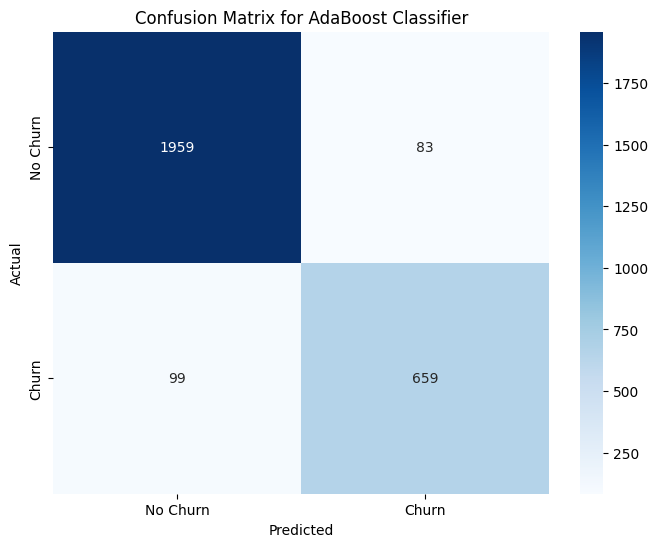

In [50]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(ytrain, y_pred_train)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for AdaBoost Classifier')
plt.show()

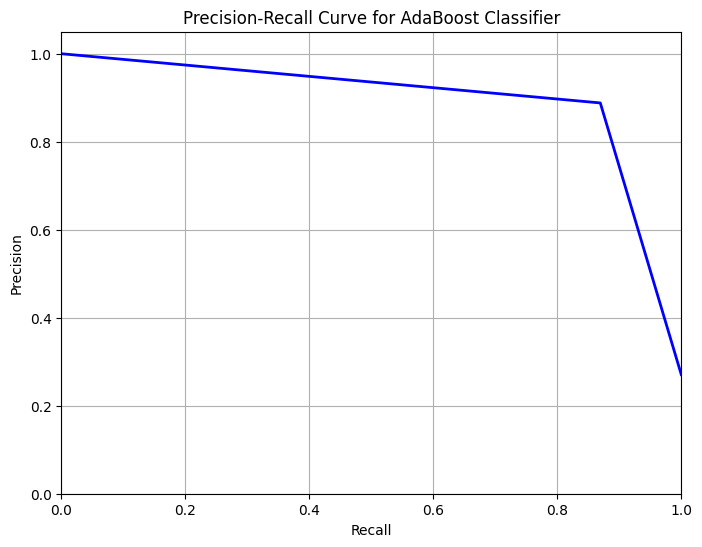

In [51]:
from sklearn.metrics import precision_recall_curve
# Compute Precision-Recall and plot curve
precision, recall, _ = precision_recall_curve(ytrain, y_pred_train)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for AdaBoost Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.show()

#### 3.1 Let's divide the data into train and validation sets.<a name="divide"></a>

#### 3.2 Let's train the model on the train set with **"Logistic regression"** method.<a name="lr"></a>

We added **`stratify=y`** inside `train_test_split` function, where y is our target variable. As a result, the dataset will be devided into two clusters. The first one will contain all the observations of class 0, while the second one – all the observations of class 1. Then, 20% of observations from each cluster will be combined into test set. This approach helps to split the data into train and test sets in a way that preserves the proportions of observations in each class as observed in the original dataset. It is important as our classes are imbalanced.

In [52]:
# for model Logistic Regression
X_lr = gym_lr.drop('churn', axis = 1)
y_lr = gym_lr['churn']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr,y_lr, test_size=0.2, random_state=0, stratify = y_lr)

In [53]:
# define the model's algorithm
lr_model = LogisticRegression(solver = 'lbfgs')
 # train our model
lr_model.fit(X_train_lr, y_train_lr)
# use the trained model to make forecasts
lr_predictions = lr_model.predict(X_test_lr)

#### 3.3 Let's train the model on the train set with **"Random forest"** method.<a name="rf"></a>

In [54]:
#We split the data into training and validation samples using the train_test_split() function.
X = gym.drop('churn', axis = 1)
y = gym['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [55]:
#We train StandardScaler on the trainig sample
scaler = StandardScaler()
scaler.fit(X_train)

#We transform the training and the validation data sets
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [56]:
# define the model's algorithm
rf_model = RandomForestClassifier(n_estimators = 500,
                                  max_features = 9,
                                  random_state = 0)
# train the random forest model
rf_model.fit(X_train, y_train)
# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
roc_value = roc_auc_score(y_test, rf_probabilities)
print("Roc_auc is {:.1%}".format(roc_value))

Roc_auc is 97.5%


In [57]:
# define the function that will output our metrics
def calculate_metrics(y_true, y_pred):
    result = []
    result.append(accuracy_score(y_true, y_pred))
    result.append(precision_score(y_true, y_pred))
    result.append(recall_score(y_true, y_pred))
    return result


In [58]:
lr_result = calculate_metrics(y_test_lr,lr_predictions)
rf_result = calculate_metrics(y_test,rf_predictions)

In [59]:
#let's built graph
xasix_list = ['Accuracy','Precision','Recall']

fig = go.Figure()
plot_bar(fig, xasix_list, lr_result, "Logistic regression", 'green')
plot_bar(fig, xasix_list, rf_result, "Random forest", 'yellow')

update_layout(fig, 'Comparison of models', '')
fig.show()

**Cross-Validation**

In [60]:
# Import the Required Libraries
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # Example model

# Load your own dataset
X = gym.drop('churn', axis=1)  # Replace 'target_column' with the name of your target column
y = gym['churn']
# Define the Model
model = RandomForestClassifier(random_state=42)
# Perform Cross-Validation
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation of accuracy:", scores.std())

Cross-validation scores: [0.9075 0.9075 0.9225 0.9225 0.915  0.925  0.9125 0.945  0.9025 0.9275]
Mean accuracy: 0.91875
Standard deviation of accuracy: 0.011845357740482133


**Notes**

Our class significantly outnumbers another (e.g., many non-churned customers and few churned ones) By using `class_weight='balanced'`, the algorithm gives more importance to the minority class during training, which can lead to better predictive performance for that class.

In [61]:
# Apply SMOTE to balance the data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# define the model's algorithm
# added class_weight= 'balanced' -
rf_model = RandomForestClassifier(n_estimators = 500,
                                  max_features = 9,
                                  random_state = 0,
                                  class_weight= 'balanced'
)
# train the random forest model
rf_model.fit(X_resampled, y_resampled)
# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
roc_value = roc_auc_score(y_test, rf_probabilities)
print("Roc_auc is {:.1%}".format(roc_value))

Roc_auc is 97.3%


In [62]:
# Retrieve and sort feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
lifetime                  0.42
frequency_current_month   0.13
contract_1m               0.11
frequency_total           0.09
age                       0.08
month_to_end              0.06
charges_for_services      0.06
group_visits              0.01
promo_friends             0.01
man                       0.01
near_location             0.01
partner                   0.01
contract_6m               0.01
phone                     0.00
contract_year             0.00
dtype: float64


In [63]:
# Indices of least important features
sorted_indices = np.argsort(feature_importances)
sorted_indices

,0
lifetime,14
frequency_current_month,13
contract_1m,12
frequency_total,11
age,10
month_to_end,9
charges_for_services,8
group_visits,7
promo_friends,6
man,5


In [64]:
# Indices of least important features
sorted_indices = np.argsort(feature_importances)
sorted_indices

,0
lifetime,14
frequency_current_month,13
contract_1m,12
frequency_total,11
age,10
month_to_end,9
charges_for_services,8
group_visits,7
promo_friends,6
man,5


In [65]:
roc_value

0.9733827493261455

In [66]:
# Set a performance threshold to determine when to stop removing features
performance_threshold = roc_value - 0.01

In [67]:
for idex in  sorted_indices:
    feature_to_drop = X_train.columns[idex]
    print(feature_to_drop)

contract_year
contract_6m
contract_1m
frequency_current_month
frequency_total
lifetime
month_to_end
charges_for_services
age
group_visits
phone
promo_friends
partner
near_location
man


In [68]:
X_reduced_train = X_train.copy()
X_reduced_test = X_test.copy()
roc_values = [roc_value]

# Start backward elimination loop
for idx in sorted_indices:
    # Drop the least important feature from both training and test sets
    feature_to_drop = X_reduced_train.columns[idx]
    X_reduced_train = X_reduced_train.drop(columns=[feature_to_drop])
    X_reduced_test = X_reduced_test.drop(columns=[feature_to_drop])

    # Train a new model without the dropped feature
    rf_model_reduce = RandomForestClassifier(n_estimators=500, random_state=0)
    rf_model_reduce.fit(X_reduced_train, y_train)

    # Evaluate model performance after feature removal
    rf_probabilities = rf_model_reduce.predict_proba(X_reduced_test)[:, 1]
    new_roc_value = roc_auc_score(y_test, rf_probabilities)
    roc_values.append(new_roc_value)

    # Print feature removal and updated ROC AUC
    print(f"Removed {feature_to_drop}, New ROC AUC: {new_roc_value:.1%}")

    # Stop if performance drops below the threshold
    if new_roc_value < performance_threshold:
        print(f"Stopping feature removal as performance dropped below threshold of {performance_threshold:.1%}.")
        break

# Final model training with remaining features
print("Final set of features used:", X_reduced_train.columns.tolist())
final_rf_model = RandomForestClassifier(n_estimators=500, max_features=9, random_state=0)
final_rf_model.fit(X_reduced_train, y_train)

Removed contract_year, New ROC AUC: 97.1%
Removed contract_6m, New ROC AUC: 97.2%
Removed contract_1m, New ROC AUC: 97.4%
Removed frequency_current_month, New ROC AUC: 94.7%
Stopping feature removal as performance dropped below threshold of 96.3%.
Final set of features used: ['man', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'age', 'charges_for_services', 'month_to_end', 'lifetime', 'frequency_total']


RandomForestClassifier(max_features=9, n_estimators=500, random_state=0)

In [69]:
testing_x = X_reduced_train[:12].copy()
testing_x

,man,near_location,partner,promo_friends,phone,group_visits,age,charges_for_services,month_to_end,lifetime,frequency_total
2702,1,1,1,0,1,1,31,56.35,6,3,0.00
1709,1,1,0,0,1,1,25,161.39,12,2,3.18
907,0,1,0,1,1,1,30,175.56,4,2,1.13
1991,0,1,1,1,1,1,25,49.84,6,0,2.39
3680,0,1,0,1,0,1,29,148.15,11,2,1.59
3632,0,1,0,0,1,1,28,434.53,1,3,0.56
1500,1,1,0,0,0,0,34,164.18,1,5,2.19
3703,0,1,1,0,1,0,35,236.66,1,4,4.39
80,1,1,1,0,1,1,28,132.14,1,1,3.72
3349,0,0,0,0,1,0,29,47.93,6,2,2.38


In [70]:
testing_x.reset_index(inplace=True, drop=True)

In [71]:
testing_x

,man,near_location,partner,promo_friends,phone,group_visits,age,charges_for_services,month_to_end,lifetime,frequency_total
0,1,1,1,0,1,1,31,56.35,6,3,0.00
1,1,1,0,0,1,1,25,161.39,12,2,3.18
2,0,1,0,1,1,1,30,175.56,4,2,1.13
3,0,1,1,1,1,1,25,49.84,6,0,2.39
4,0,1,0,1,0,1,29,148.15,11,2,1.59
5,0,1,0,0,1,1,28,434.53,1,3,0.56
6,1,1,0,0,0,0,34,164.18,1,5,2.19
7,0,1,1,0,1,0,35,236.66,1,4,4.39
8,1,1,1,0,1,1,28,132.14,1,1,3.72
9,0,0,0,0,1,0,29,47.93,6,2,2.38


In [72]:
import pickle

# Save the trained model to a file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(final_rf_model, file)
print("Model saved as 'random_forest_model.pkl'")

from google.colab import files
# Download the saved model
files.download('random_forest_model.pkl')

Model saved as 'random_forest_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Conclusion: <br /><br />
The "Random forest" model shows the best result for all metrics. We have unbalanced data, so the Accuracy metric won't work well. For our business problem, the Recall metric is more relevant, because we need to minimize the number of falsely negative cases when the model is mistaken and informs us that the client does not plan to stop training. Thus, we need to choose the Random forest model.
    

# **Clusterisation**

We have decided on a model that predicts the likelihood of customer churn depending on the features of a given customer. Now let's devide our clients into clusters. Our objective is to group users based on their behavior patterns and predict their likelihood to churn. To achieve this, we will follow the below steps:

  •	Train the clustering model with the **K-means** algorithm and predict customer clusters using the **n_clusters** parameter determined from the dendrogram analysis.

   •	Look at the mean feature values for each cluster and plot distributions of features for the clusters to identify any noticeable patterns or differences between them.

   •	Calculate the churn rate for each cluster using the groupby() method to determine if there are any significant differences in terms of churn rate between the clusters.

### Step 4. Create user clusters<a name="clusters"></a>

#### 4.1 Standardize the data and plot a dendrogram<a name="dendrogram"></a>

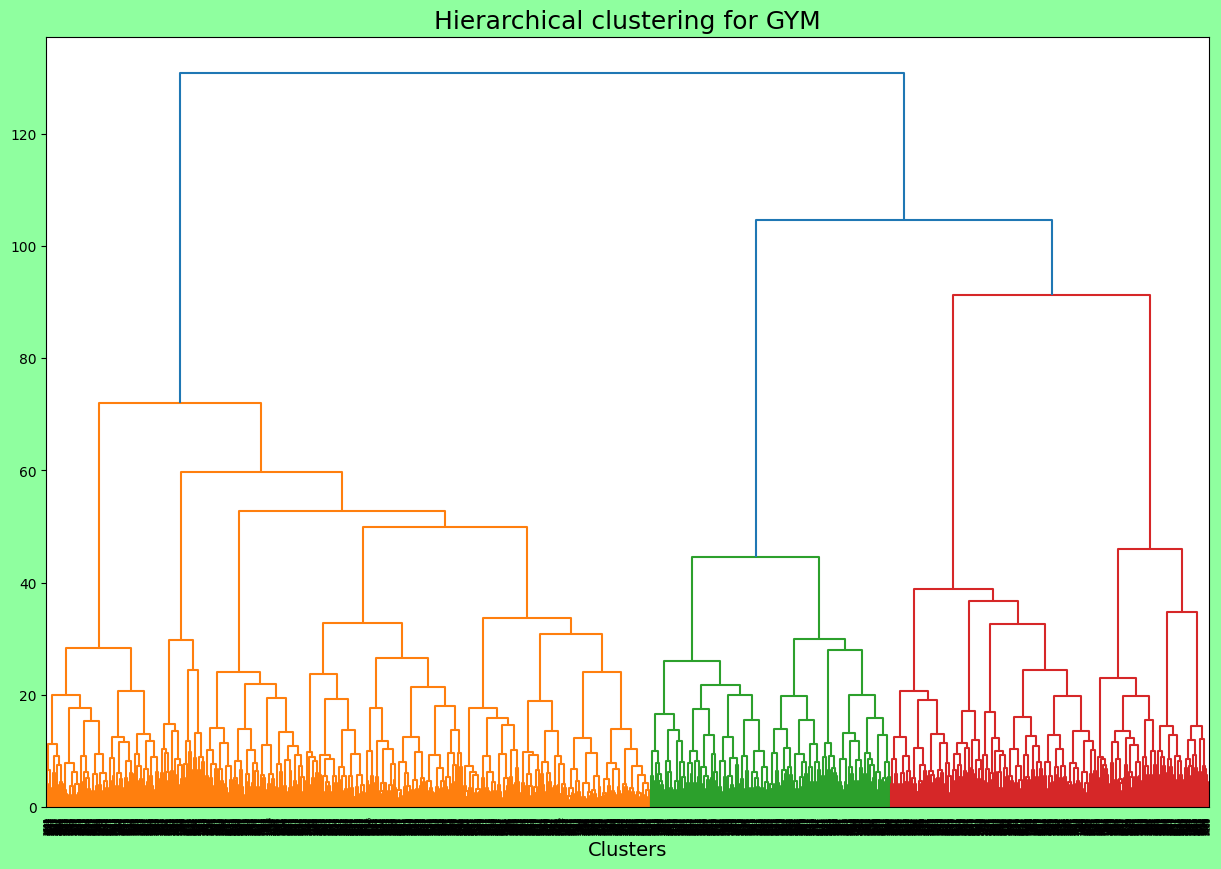

In [73]:
# Scale the data
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
# Perform hierarchical clustering
linked = linkage(X_sc, method = 'ward')
# Build dendrogram
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('xkcd:mint green')
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for GYM', fontsize=18)
ax.set_xlabel('Clusters', fontsize=14)
plt.show()

Conclusion:<br /><br />
The resulting dendrogram illustrates the hierarchical clustering structure of the dataset, grouping similar objects (customers) based on the distance between their standardized feature values. Each horizontal line in the dendrogram signifies the distance between the clusters being merged at that point, with longer lines indicating greater differences between clusters. To estimate the number of distinct clusters, one can identify the vertical lines that extend the furthest without intersecting any horizontal lines. This maximum distance helps determine the optimal number of clusters for the dataset

#### 4.2 Let's train the model on the train set with "K-means" algorithm.<a name="k_means"></a>

In [74]:
# define the k_means model with 5 clusters
km = KMeans(n_clusters = 4, random_state = 0)
labels = km.fit_predict(X_sc)
# store cluster labels into the field of our dataset
gym['cluster'] = labels

##### Let's check how well the algorithm managed to divide clients into clusters.

In [75]:
# Let's check how well the algorithm managed to divide clients into clusters
print('Silhouette score is {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette score is 0.16


The assessment of the quality of dividing clients into clusters is not high, which means that clients from one cluster are to some extent similar to clients from other clusters.

#### 4.3 The mean feature values for clusters.<a name="mean"></a>

In [76]:
# display statistics on the average values of our features for the cluster
gym.groupby(['cluster']).mean().T

cluster,0,1,2,3
man,0.51,0.54,0.48,0.52
near_location,0.93,0.87,0.75,0.86
partner,0.72,0.36,0.35,0.58
promo_friends,0.48,0.25,0.18,0.37
phone,0.90,0.91,0.90,0.90
group_visits,0.54,0.43,0.28,0.44
age,29.82,30.07,27.87,29.55
charges_for_services,163.59,157.71,124.20,151.65
month_to_end,10.84,1.00,1.00,5.62
lifetime,4.66,4.82,2.01,4.14


Dividing clients into 4 clusters using the K-means algorithm, we can draw the following conclusions:<br /><br />
- Clients who got into clusters 1, 2, and 3 are loyal and the probability that they will left is minimal, especially for clients who got into cluster 1.
- Clients who got into cluster 0 with a probability of more than 50% will stop attending the gym.
- Clients who live close to fall into cluster 0.
- Cluster 0 does not include clients who came from friends through promotions and like group lessons least of all.
- Average age and gender are distributed almost equally among all clusters.
- Clients who have a contract for more than 1 month fall into groups 0 and 3.
- Clients from Cluster 1 bought a 6-month contract.
- Clients from Cluster 2 bought a one-year contract.
- Clients who frequently go to the gym are in cluster 3, those who are rarely to go to the gym are in cluster 0

#### 4.4 Plot distributions of features for the clusters.<a name="distributions"></a>

In [77]:
category_data_list = ['man',
                      'near_location',
                      'partner',
                      'promo_friends',
                      'phone',
                      'group_visits',
                      'contract_1m',
                      'contract_6m',
                      'contract_year']
numeric_data_list = ['charges_for_services',
                     'month_to_end',
                     'lifetime',
                     'frequency_current_month',
                     ]

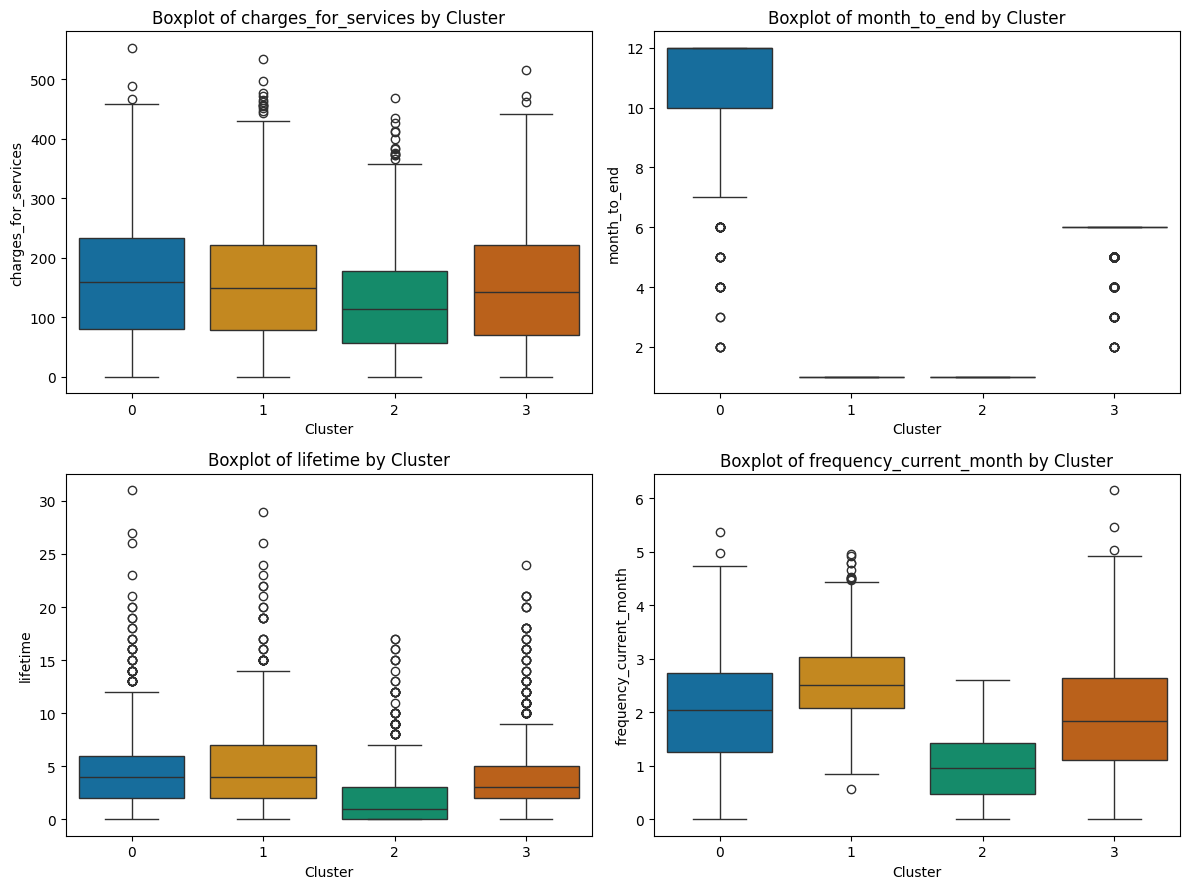

In [78]:
# Create a figure with subplots
n_rows = 2
n_cols = 2  # Adjust according to the number of numeric variables
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 9), sharex=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create boxplots for each numeric variable
for idx, column in enumerate(numeric_data_list):
    ax = sns.boxplot(x='cluster', y=column, data=gym, ax=axes[idx], palette="colorblind", hue='cluster', legend=False)
    ax.set_title(f'Boxplot of {column} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

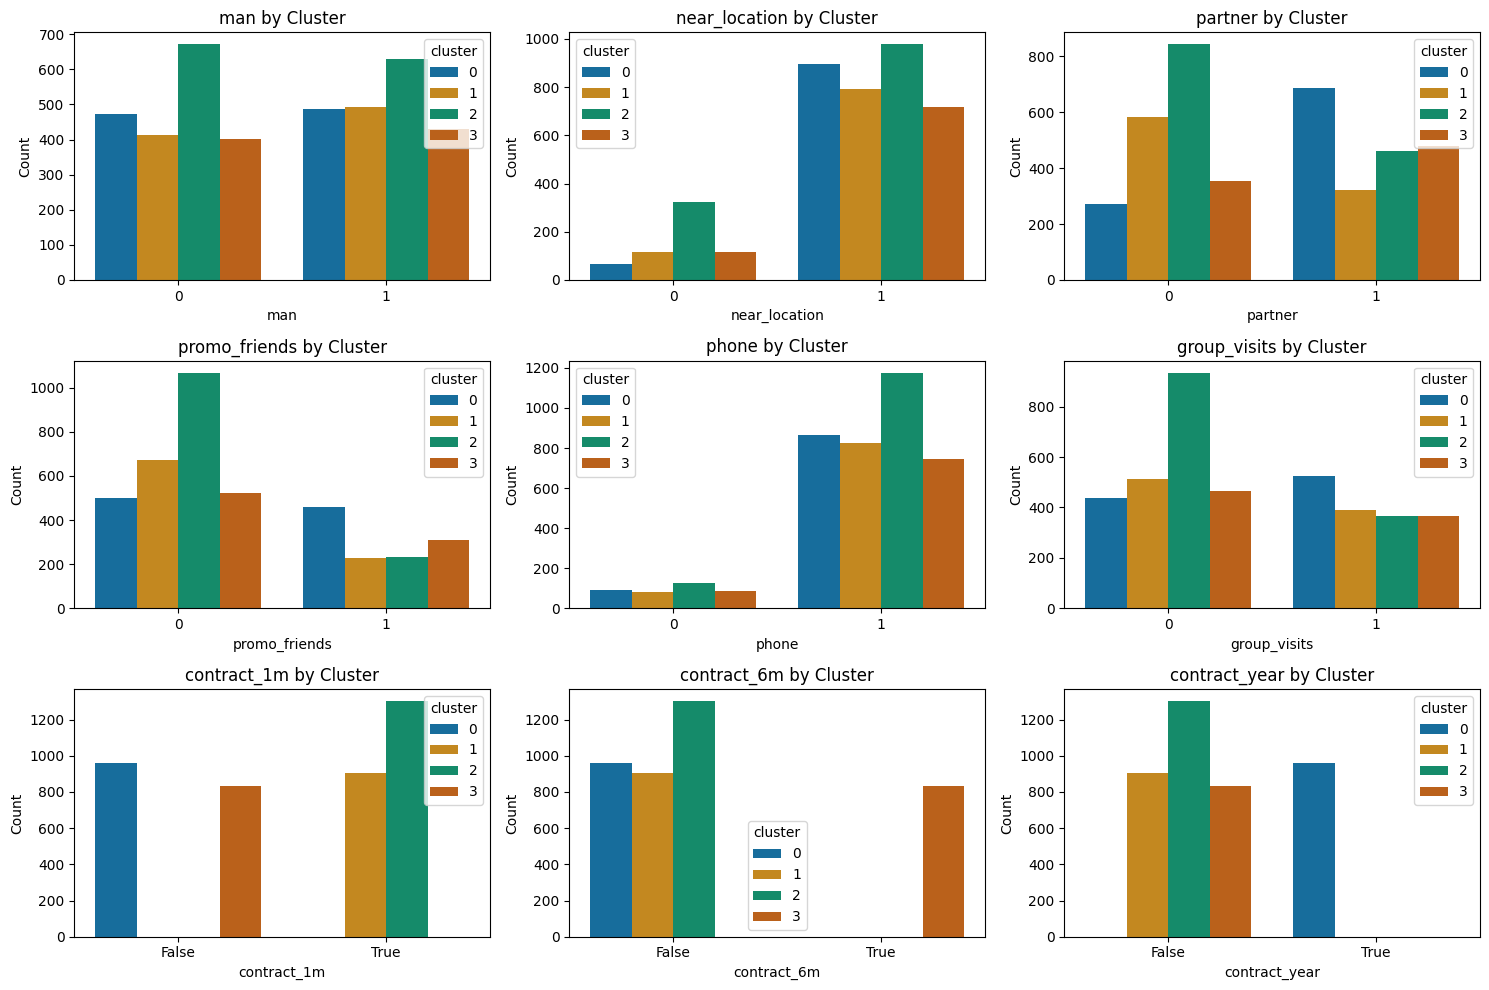

In [79]:
# Create a figure with subplots
n_rows = 3  # Adjust based on how many categorical variables you have
n_cols = 3  # Adjust according to the number of categorical variables
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create countplots for each categorical variable
for idx, column in enumerate(category_data_list):
    ax = sns.countplot(x=column, hue='cluster', data=gym, ax=axes[idx], palette="colorblind")
    ax.set_title(f'{column} by Cluster')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

As we can see, in the main, the clusters overlap strongly. <br />
The following features have an explicit division into clusters:<br />
- month_to_end
- contract_6m
- contract_year



#### 4.5 Calculate the churn rate for each cluster<a name="calculate"></a>

In [ ]:
cluster = (
    gym.query('churn == 1').
    groupby('cluster').
    agg({'cluster':'count'}).
    rename(columns={'cluster':'churn'}).
    reset_index()
)
cluster['total'] = gym.groupby('cluster').agg({'cluster':'count'})
cluster['ratio_churn'] = cluster['churn'] / cluster['total']
cluster

,cluster,churn,total,ratio_churn
0,0,23,960,0.02
1,1,99,904,0.11
2,2,835,1303,0.64
3,3,104,833,0.12


In [ ]:
#let's built graph
xasix_list = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4']

fig = go.Figure()
plot_bar(fig, xasix_list, cluster['ratio_churn'], "", 'green')
# plot_bar(fig, xasix_list, rf_result, "Random forest", 'yellow')

update_layout(fig, 'The churn rate for each cluster ', '')
fig.show()

Conclusion: <br />
As we can see, clusters vary greatly in terms of churn rate. Cluster 0 has the lowest churn rate (2.4%). Clients from clusters 1 and 3 are also quite loyal and their churn rate is less 13%. Clients in cluster 2 is more than 60% likely to quit.

Here are the general characteristics of customers who are more likely to churn: most of them have a lifetime below three months, visit less than twice a week, get lower promo_friends, the average additional extra charge below 125 USD, and they still have remaining contract period for about four months.

We can characterize clients from clusters as follows: <br /><br />
##### Cluster 0:
- These are the most loyal customers with a churn rate of 2%.
- They live close to the gym
- They buy a contract for year
- They go to the gym more than 2 times a week
- They tend to attend group classes
- The 48% came by invitation of friends
- They have been in the gym for about 4 months
- Most of them work in partner firms
<br /><br />
##### Cluster 1:
- They tend to keep exercising, 10% chance of churn
- They live close to the gym
- They buy a contract for a month
- They go to the gym more than 2.6 times a week
- They tend to attend group classes
- The 25% came by invitation of friends
- They have been in the gym for about 5 months
<br /><br />
##### Cluster 2:
- They tend to stop exercising, more than 60% likely.
- They live far from the gym.
- They buy a contract for a month.
- They go to the gym on average 1.5 times a week
- They rarely go to group classes
- They rarely come at the invitation of friends
- They have been in the gym for about 2.5 months
<br /><br />
##### Cluster 3:
- They tend to keep exercising, 12% chance of churn
- They live close to the gym
- They buy a contract for 6 months
- They go to the gym more than 2 times a week
- They tend to attend group classes
- The 38% came by invitation of friends
- They have been in the gym for about 4 months

### Step 5.  Conclusions and basic recommendations<a name="conclusions"></a>

#### 5.1 Overall conclusion.<a name="overall_conclusion"></a>

After analyzing clients attending the gym, we determined that the Random Forest model is the best way to predict churn. We divided all clients into 4 clusters and described the features of each cluster. As a result, it turned out that customers from clusters 1, 2, and 3 are loyal and do not plan to stop exercising, and customers from cluster 0 are likely to stop exercising in the near future. <br /><br />

We also compiled a portrait of a client who tends to stop exercising:
- has a monthly contract
- goes to the gym less than 1 time per week
- doesn't like group training
- rarely comes at the invitation of friends <br /> <br />

#### 5.2 Recommendations.<a name="recommendations"></a>

As we can see, most often the clients who have recently bought a contract for a month stop exercising. They may not be sure if they will like it and want to try it. It is very important to pay special attention to such clients. You need to conduct free conversations with them. It is necessary to understand their needs and advise ways of solving them. It is necessary to make the client understand that the club is directly interested and responsible for their achievement. <br /><br />

We also see that if a client visits the gym less than 1 time per week, then there is a high probability that he will soon stop exercising. You need to hold individual meetings with them and try to find out the reason for the loss of interest in training. Perhaps the client does not know how to achieve the desired result. Together with the client, you need to create a detailed monthly plan for moving towards the assigned tasks. The plan must be agreed upon with the client and with the coaches and be in the nature of the client's commitment to himself and to the club. <br /><br />

It is very important not to lose touch with the client so that he does not feel left to fend for himself. It is necessary to regularly offer the client nutritional advice, body composition testing, relaxation sessions, invite them to meetings with a dietitian and physiotherapist. <br />